In [1]:
!pip install umap-learn
!pip install datashader
!pip install holoviews

     |████████████████████████████████| 69 kB 152 kB/s  eta 0:00:01
  Created wheel for umap-learn: filename=umap_learn-0.4.6-py3-none-any.whl size=67950 sha256=1c4ca069a5cffe1400b5152dc512c2d7dbb3accf7cf47a257edc249d22cb3906
  Stored in directory: /home/ec2-user/.cache/pip/wheels/22/ce/3d/75f6600b4d93c851021aceeec51b7b330c0ad4d9692e69be6a
Successfully built umap-learn
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 15.5 MB 11.4 MB/s eta 0:00:01
     |████████████████████████████████| 704 kB 58.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 42.1 MB/s eta 0:00:01
     |████████████████████████████████| 76 kB 1.1 MB/s  eta 0:00:01
     |████████████████████████████████| 70 kB 13.0 MB/s eta 0:00:01
  Created wheel for datashape: filename=datashape-0.5.2-py3-none-any.whl size=59427 sha256=73fd24a756f40d4ce2d742367ca614799dd55684d8b8aa4d58de95f8ee

In [32]:
import pandas as pd
import json
import numpy as np
from pandas.io.json import json_normalize
from bokeh.plotting import show, save, output_notebook, output_file
import umap
import umap.plot
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
import seaborn as sns
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
from sklearn.cluster import DBSCAN, KMeans
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score


Pull in SPECTER embeddings + the meta data info on the theses

In [3]:
s3_path_embeddings_df = "s3://lgo-theses-test/dict_all_embeddings.csv"
merged_df_path = "s3://lgo-theses-test/merged_mimo_df.csv"

In [4]:
specter_embeddings_df = pd.read_csv(s3_path_embeddings_df)
thesis_df = pd.read_csv(merged_df_path)

In [6]:
#Clean up column headings of specter embeddings df
specter_embeddings_df['thesis_id']= specter_embeddings_df['Unnamed: 0']
specter_embeddings_df = specter_embeddings_df.drop(columns=['Unnamed: 0'])

#Clean up column headings of merged df (meta data on theses)
thesis_df['thesis_id']=thesis_df['Unnamed: 0']
thesis_df = thesis_df.drop(columns=['Unnamed: 0'])

Uncomment this next block if want to start from json dump

In [7]:
'''with open('dict_all_embeddings.json') as json_file:
    json_data = json.load(json_file)

embeddings_df = pd.DataFrame.from_dict(json_data, orient='index')
embeddings_df.to_csv(s3_path_embeddings_df)
 '''   

Clean up duplicates from both specter embeddings and the thesis metadata

In [11]:
dupes_df = thesis_df[thesis_df.duplicated(subset=['filenames'],keep='first')]
dupes_ids = list(dupes_df.thesis_id)

In [12]:
thesis_df_dupes_dropped = thesis_df[~thesis_df['thesis_id'].isin(dupes_ids)]
specter_embeddings_df_dupes_dropped = specter_embeddings_df[~specter_embeddings_df['thesis_id'].isin(dupes_ids)]

Put thesis_id as index so can do subsequent UMAP dimensionality reduction and K means clustering

In [14]:
specter_embeddings_df_dupes_dropped.index = specter_embeddings_df_dupes_dropped['thesis_id']
specter_embeddings_df_dupes_dropped = specter_embeddings_df_dupes_dropped.drop(columns= ['thesis_id'])

In [15]:
reducer = umap.UMAP()

In [16]:
embedding = reducer.fit_transform(specter_embeddings_df_dupes_dropped)

(1056, 2)

In [19]:
specter_embeddings_thesis_ids = list(specter_embeddings_df_dupes_dropped.index)

In [20]:
#filter thesis_df to only the indices of the embeddings_df
thesis_df_filtered = thesis_df[thesis_df['thesis_id'].isin(specter_embeddings_thesis_ids)]

In [21]:
thesis_df_filtered.shape, specter_embeddings_df_dupes_dropped.shape

((1056, 16), (1056, 768))

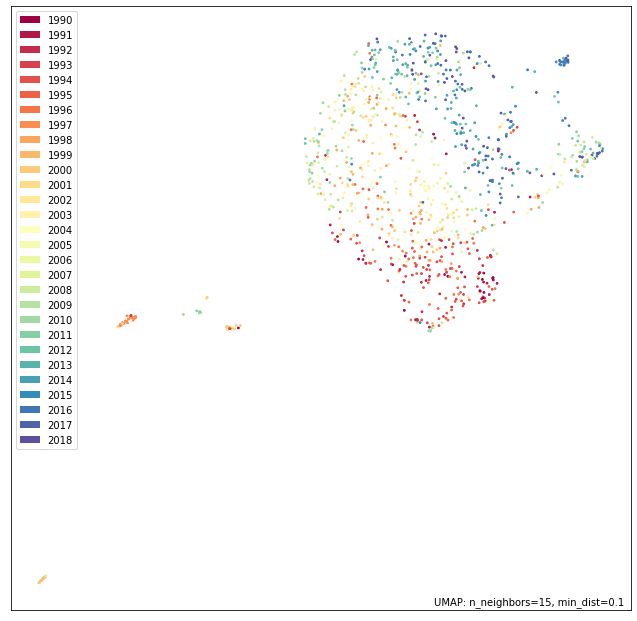

In [71]:
umap.plot.points(reducer, labels= thesis_df_filtered['CLASS_x'])


Add in information on the partner company and industry

In [27]:
aero =['Spirit AeroSystems Inc.','United Technologies Corporation','Raytheon-Space and Airborne Systems','The Boeing Company',
      'United Technologies Corporation - Pratt & Whitney','Raytheon Company','Bell Helicopter','United Technologies Corporation - Sikorsky Aircraft',
      'Raytheon - Integrated Defense Systems','United Technologies Corporation - Aerospace Systems','General Dynamics Corporation','Lincoln Laboratory ',
      'Northrop Grumman Corporation','GE Aviation','Raytheon - Intelligence and Information Systems','NASA']

healthcare =['Broad Institute','Amgen Inc.','Genzyme Corporation','Novartis Pharma AG','Johnson & Johnson','Boston Scientific',
            'Novartis Institutes for Biomedical Research, Inc.','Pfizer','Sanofi','Novartis Vaccine and Diagnostics',
            'Massachusetts General Hospital','Beth Israel Deaconess Medical Center','Quest Diagnostics','Genentech',
            'Novartis Biologics','Danaher ','PerkinElmer, Inc.']

hitech=['Honeywell International Incorporated','Intel Corporation','Cisco Systems Incorporated','SanDisk Corporation',
       'Cisco/Flextronics','Hewlett-Packard Company','Digital Equipment Corporation','Lucent Technologies Incorporated',
       'Flextronics','Motorola Incorporated','Nokia Corporation', 'Polaroid Corporation','3M Company','iRobot','Eastman Kodak Company',
       'Dell, Inc.','MASCHINENFABRIK REINHAUSEN GMBH','MASCHINENFABRIK REINHAUSEN','Teradyne Incorporated','ABB ',
       'ABB Limited','ATI Technologies, Inc.','Axcelis Technologies Incorporated','American Industrial Partners']

auto=['Ford Motor Company','Harley-Davidson Motor Company','General Motors Corporation','Goodyear Tire and Rubber Company',
     'Caterpillar','American Axle and Manufacturing','Valeo SA']

attire = ['Nike','Li & Fung','Zara (Inditex, S.A.)']

utilities = ['National Grid', 'Pacific Gas & Electric','Schlumberger','Siemens Power Transmission and Distribution','Verizon']

consumer = ['Amazon ','Kimberly Clark Corp.','The Procter & Gamble Company','Pepsi Bottling Group','Pepsi Bottling Company',
           'C&S Wholesale Grocers','Amazon.com Incorporated']

rawmaterials=['H.C. Starck GmbH','Aluminum Company of America','BMHC']

mapping_dict = {'aero':aero, 'healthcare':healthcare, 'hitech':hitech,'auto':auto,'attire':attire,'utilities':utilities,
               'consumer':consumer,'rawmaterials':rawmaterials}
industries= ['aero','healthcare','hitech','auto','attire','utilities','consumer','rawmaterials']

In [28]:
#Swap keys for values so that each partner company maps to an industry
new_dict = {k: oldk for oldk, oldv in mapping_dict.items() for k in oldv}
thesis_df_filtered['industry'] = thesis_df_filtered.INTERNSHIP_COMPANY
thesis_df_filtered['industry'] = thesis_df_filtered.INTERNSHIP_COMPANY.map(new_dict)
thesis_df_filtered["industry"] = thesis_df_filtered["industry"].astype('category')
thesis_df_filtered["industry_cat"] = thesis_df_filtered["industry"].cat.codes

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [29]:
thesis_df_filtered['industry'] = thesis_df_filtered['industry'].cat.add_categories("notknown").fillna('notknown')

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Interactive bokeh plotting 

In [30]:
hover_data = thesis_df_filtered[['CLASS_x', 'THESIS_TITLE', 'ENG_DEPT','INTERNSHIP_COMPANY', 'industry']]

Find a specific thesis to evaluate for spot checking

In [53]:
thesis_df_evaluate = thesis_df_filtered[thesis_df_filtered['LAST_NAME_x']=="Arnold"]

In [54]:
thesis_df_evaluate

,0,filenames,FIRST_NAME_x,LAST_NAME_x,THESIS_TITLE,CLASS_x,THESIS_TITLE.1,Theses,MIT_ID,PERSON_ID,FIRST_NAME_y,LAST_NAME_y,CLASS_y,ENG_DEPT,INTERNSHIP_COMPANY,thesis_id,industry,industry_cat
371,Wafer Defect Prediction with Statistical Machi...,Naomi_SanDisk_thesis_final_May04_2016,Naomi,Arnold,Wafer Defect Prediction with Statistical Machi...,2016,Naomi_SanDisk_thesis_final_May04_2016.pdf,Wafer Defect Prediction with Statistical Machi...,974094095.0,48180,Naomi,Arnold,2016,Engineering Systems Division,SanDisk Corporation,371,hitech,5


Calculate pairwise cosine similarity distance

In [41]:
pairwise_top = pd.DataFrame(
    squareform(pdist(specter_embeddings_df_dupes_dropped, metric='cosine')),
    columns = specter_embeddings_df_dupes_dropped.index,
    index = specter_embeddings_df_dupes_dropped.index
)

In [55]:
pairwise_top.sort_values(by=[371])

thesis_id,0,1,2,3,4,5,6,7,8,9,...,1298,1299,1300,1301,1302,1303,1304,1305,1306,1307
thesis_id,,,,,,,,,,,,,,,,,,,,,
371,0.272391,0.316158,0.262297,0.266420,0.418487,0.433224,0.263488,0.292765,0.327040,0.307752,...,0.326863,0.248218,0.170261,0.335046,0.240869,0.338318,0.273545,0.274233,0.224489,0.317828
1300,0.180984,0.198528,0.203249,0.191396,0.289733,0.360925,0.203679,0.243201,0.262760,0.211223,...,0.233241,0.261075,0.000000,0.245457,0.230222,0.236966,0.201352,0.191135,0.188336,0.213491
390,0.306152,0.257474,0.303527,0.272742,0.440230,0.403204,0.297087,0.272913,0.354772,0.341421,...,0.337672,0.256420,0.228892,0.302767,0.240558,0.317206,0.253942,0.264246,0.263837,0.307736
747,0.202181,0.276246,0.258749,0.231977,0.390550,0.408057,0.250745,0.218206,0.275870,0.281539,...,0.300301,0.227738,0.166611,0.280478,0.208609,0.254783,0.217607,0.203979,0.252372,0.295426
315,0.224225,0.295056,0.276047,0.195947,0.358848,0.444547,0.216152,0.255022,0.224664,0.249142,...,0.344459,0.225932,0.213819,0.317721,0.195730,0.294377,0.210118,0.199928,0.267030,0.278607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
904,0.798863,0.835215,0.918537,0.800507,0.756366,0.787673,0.806028,0.801720,0.813295,0.831198,...,0.954573,0.829502,0.859006,0.894923,0.821135,0.891489,0.827221,0.859318,0.899168,0.735457
1156,0.749475,0.750388,0.818937,0.827730,0.684475,0.812280,0.885775,0.839799,0.830652,0.795421,...,0.823929,0.855692,0.772893,0.820626,0.892636,0.843066,0.740038,0.801016,0.865508,0.768690
622,0.759395,0.681105,0.857482,0.800227,0.668949,0.770728,0.862694,0.862130,0.843538,0.796184,...,0.808825,0.858600,0.777052,0.837555,0.903554,0.822998,0.732429,0.793085,0.873633,0.750272


In [56]:
#others_to_look_at = [14,323,849,1137]
#others_to_look_at = [576,931,1214,410,394]
others_to_look_at = [371,1300,390,747,315]

In [57]:
thesis_df_related = thesis_df_filtered[thesis_df_filtered['thesis_id'].isin(others_to_look_at)]

In [58]:
thesis_df_related

,0,filenames,FIRST_NAME_x,LAST_NAME_x,THESIS_TITLE,CLASS_x,THESIS_TITLE.1,Theses,MIT_ID,PERSON_ID,FIRST_NAME_y,LAST_NAME_y,CLASS_y,ENG_DEPT,INTERNSHIP_COMPANY,thesis_id,industry,industry_cat
315,A Framework for Analyzing Forecast Accuracy Me...,MIT Thesis - Yalu Wu FINAL 5-1-15,Yalu,Wu,A Framework for Analyzing Forecast Accuracy Me...,2015,MIT Thesis - Yalu Wu FINAL 5-1-15.pdf,A Framework for Analyzing Forecast Accuracy Me...,962778095.0,46436,Yalu,Wu,2015,Civil and Environmental Engineering,Nike,315,attire,1
371,Wafer Defect Prediction with Statistical Machi...,Naomi_SanDisk_thesis_final_May04_2016,Naomi,Arnold,Wafer Defect Prediction with Statistical Machi...,2016,Naomi_SanDisk_thesis_final_May04_2016.pdf,Wafer Defect Prediction with Statistical Machi...,974094095.0,48180,Naomi,Arnold,2016,Engineering Systems Division,SanDisk Corporation,371,hitech,5
390,Wires-Down Predictive Modeling and Preventativ...,gesch16thesis,Gregory,Eschelbach,Wires-Down Predictive Modeling and Preventativ...,2016,gesch16thesis.pdf,Wires-Down Predictive Modeling and Preventativ...,918772269.0,48102,Gregory,Eschelbach,2016,Engineering Systems Division,Pacific Gas & Electric,390,utilities,7
747,A Predictive Approach for Identifying High Per...,2015.4.20_AChan_LGO_Thesis 2,Albert,Chan,A Predictive Approach for Identifying High Per...,2015,2015.4.20_AChan_LGO_Thesis 2.pdf,A Predictive Approach for Identifying High Per...,992270777.0,46215,Albert,Chan,2015,Engineering Systems Division,Li & Fung,747,attire,1
1300,Leveraging Statistical Process Control for Con...,LGO Thesis_Fuller_Final,Stephen,Fuller,Leveraging Statistical Process Control for Con...,2015,LGO Thesis_Fuller_Final.pdf,Leveraging Statistical Process Control for Con...,926776609.0,46243,Stephen,Fuller,2015,Engineering Systems Division,Amgen Inc.,1300,healthcare,4


Trying K Means

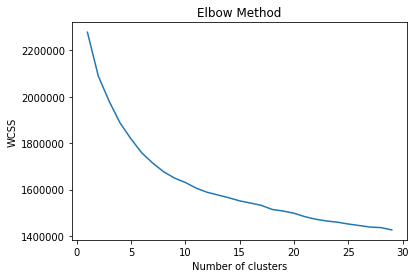

In [61]:
wcss = []
for i in range(1, 30):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(specter_embeddings_df_dupes_dropped)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 30), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [64]:
kmeans = KMeans(n_clusters=10, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans_cluster_labels = kmeans.fit_predict(specter_embeddings_df_dupes_dropped)

In [85]:
kmeans_cluster_labels_df = pd.DataFrame(data=cluster_labels)
thesis_df_filtered_merged_kmeans_clustering = thesis_df_filtered.join(kmeans_cluster_labels_df)
thesis_df_filtered_merged_kmeans_clustering['cluster_label']=thesis_df_filtered_merged_kmeans_clustering[0]

Preparing for analysis of the assigned clusters

In [86]:
thesis_df_filtered_merged_kmeans_clustering_onehot = pd.get_dummies(thesis_df_filtered_merged_kmeans_clustering, columns=['industry'])

In [87]:
thesis_df_filtered_merged_kmeans_clustering_onehot.groupby('cluster_label')['CLASS_x'].mean()

cluster_label
0.0    2005.369231
1.0    2004.413333
2.0    2005.296296
3.0    2003.137931
4.0    2005.460606
5.0    2004.277778
6.0    2004.878049
7.0    2001.600000
8.0    2004.578947
9.0    2005.101266
Name: CLASS_x, dtype: float64

In [88]:
thesis_df_filtered_merged_kmeans_clustering_onehot.groupby('cluster_label')['CLASS_x'].std()

cluster_label
0.0    8.749231
1.0    8.120888
2.0    8.229488
3.0    7.605093
4.0    8.181998
5.0    8.483933
6.0    8.518201
7.0    8.443933
8.0    7.684088
9.0    8.388935
Name: CLASS_x, dtype: float64

In [89]:
thesis_df_filtered_merged_kmeans_clustering_onehot.groupby('cluster_label').count()

,0,filenames,FIRST_NAME_x,LAST_NAME_x,THESIS_TITLE,CLASS_x,THESIS_TITLE.1,Theses,MIT_ID,PERSON_ID,...,0,industry_aero,industry_attire,industry_auto,industry_consumer,industry_healthcare,industry_hitech,industry_rawmaterials,industry_utilities,industry_notknown
cluster_label,,,,,,,,,,,,,,,,,,,,,
0.0,65,65,65,65,65,65,65,65,64,65,...,65,65,65,65,65,65,65,65,65,65
1.0,150,150,150,150,150,150,150,150,143,150,...,150,150,150,150,150,150,150,150,150,150
2.0,108,108,108,108,108,108,108,108,105,108,...,108,108,108,108,108,108,108,108,108,108
3.0,29,29,29,29,29,29,29,29,27,29,...,29,29,29,29,29,29,29,29,29,29
4.0,165,165,165,165,165,165,165,165,160,165,...,165,165,165,165,165,165,165,165,165,165
5.0,18,18,18,18,18,18,18,18,18,18,...,18,18,18,18,18,18,18,18,18,18
6.0,41,41,41,41,41,41,41,41,39,41,...,41,41,41,41,41,41,41,41,41,41
7.0,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
8.0,171,171,171,171,171,171,171,171,168,171,...,171,171,171,171,171,171,171,171,171,171


In [90]:
thesis_df_filtered_merged_kmeans_clustering_onehot[thesis_df_filtered_merged_kmeans_clustering_onehot['cluster_label']==5].describe()

,CLASS_x,MIT_ID,PERSON_ID,CLASS_y,thesis_id,industry_cat,0,cluster_label,industry_aero,industry_attire,industry_auto,industry_consumer,industry_healthcare,industry_hitech,industry_rawmaterials,industry_utilities,industry_notknown
count,18.000000,1.800000e+01,18.000000,18.000000,18.000000,18.00000,18.0,18.0,18.0,18.0,18.000000,18.000000,18.000000,18.0,18.0,18.0,18.000000
mean,2004.277778,9.519506e+08,20677.666667,2004.277778,571.944444,1.00000,5.0,5.0,0.0,0.0,0.055556,0.111111,0.277778,0.0,0.0,0.0,0.555556
std,8.483933,2.761037e+07,19565.565279,8.483933,313.441518,2.35147,0.0,0.0,0.0,0.0,0.235702,0.323381,0.460889,0.0,0.0,0.0,0.511310
min,1993.000000,9.208415e+08,2563.000000,1993.000000,25.000000,-1.00000,5.0,5.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
25%,1996.750000,9.254922e+08,3931.500000,1996.750000,391.750000,-1.00000,5.0,5.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
50%,2004.000000,9.504289e+08,6970.500000,2004.000000,635.000000,-1.00000,5.0,5.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.000000
75%,2011.750000,9.743540e+08,40834.500000,2011.750000,840.000000,3.75000,5.0,5.0,0.0,0.0,0.000000,0.000000,0.750000,0.0,0.0,0.0,1.000000
max,2018.000000,9.996894e+08,50486.000000,2018.000000,1000.000000,4.00000,5.0,5.0,0.0,0.0,1.000000,1.000000,1.000000,0.0,0.0,0.0,1.000000


Save updated df to s3 so can join it with the results from comprehend topic modeling 

In [91]:
s3_kmeans_thesis_df_path_onehot = "s3://lgo-theses-test/kmeans_thesis_df_onehot.csv"
s3_kmeans_thesis_df_path_ = "s3://lgo-theses-test/kmeans_thesis_df_1.csv"

In [92]:
thesis_df_filtered_merged_kmeans_clustering_onehot.to_csv(s3_kmeans_thesis_df_path_onehot)
thesis_df_filtered_merged_kmeans_clustering.to_csv(s3_kmeans_thesis_df_path_)

In [94]:
thesis_df_filtered_merged_kmeans_clustering.to_csv("s3://lgo-theses-test/kmeans_thesis_df_1.csv")

In [96]:
test_df = pd.read_csv("s3://lgo-theses-test/kmeans_thesis_df_1.csv")